# Predicting KPIs for QQ2: Publications and Open Source Software


In order to make reliable forecasts for planning and goal setting in the new quinquennium, this notebook uses a times series modelling approach to predict and visualise the monthly number of publications and monthly open source repositories. 

The input data includes retrospective monthly measurements of each KPI alongside date flags.

In [1]:
##Import Packages
import pandas as pd
from prophet import Prophet
from prophet.plot import plot, add_changepoints_to_plot
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')

pd.set_option('display.max_rows', 250)
%matplotlib inline
#print(plt.style.available)

Importing plotly failed. Interactive plots will not work.


In [2]:
##Import data
df = pd.read_csv(r'C:\Users\HollydawnMurray\Documents\KPIs(3).csv',parse_dates = ['Month'])

print('Dataset Shape:', df.shape)
print('Min Obs. Date:',df['Month'].min())
print('Max Obs. Date:',df['Month'].max())
df.head()


Dataset Shape: (45, 5)
Min Obs. Date: 2020-04-01 00:00:00
Max Obs. Date: 2023-12-01 00:00:00


,Month,Publications,Software,First_Month,Last_Month
0,2020-04-01,23.0,6.0,0.0,0.0
1,2020-05-01,42.0,9.0,0.0,0.0
2,2020-06-01,20.0,1.0,0.0,1.0
3,2020-07-01,17.0,2.0,0.0,0.0
4,2020-08-01,18.0,9.0,0.0,0.0


Text(0.5, 1.0, 'Open source software per month')

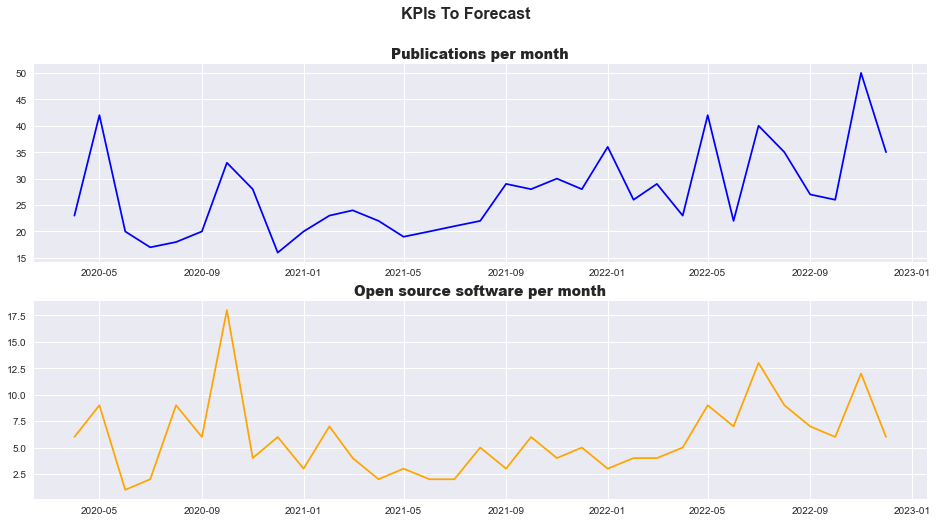

In [3]:
#Plot KPIs
fig, (ax1, ax2) = plt.subplots(2, figsize = (16, 8))
fig.suptitle('KPIs To Forecast', fontsize=16, fontweight="bold")

ax1.plot(df['Month'], df['Publications'], color = 'blue')
ax2.plot(df['Month'], df['Software'], color = 'orange')

ax1.set_title('Publications per month', fontsize=14,fontweight='heavy')
ax2.set_title('Open source software per month', fontsize=14, fontweight='heavy' )

In [4]:
#create time stamps and model
cutoff_date = pd.to_datetime('2022-12-01') #last date to include in train
test_end_date = pd.to_datetime('2023-01-01') #last date to include in test

forecast_start_date = pd.to_datetime('2022-12-01') #first date of forecast
forecast_end_date = pd.to_datetime('2023-12-01') #last date of forecast




kpis = ['Publications']


for kpi in kpis:
    print('Forecasting KPI: ', kpi)
    df_train = df.loc[(df[kpi].notnull()) & (df['Month'] <= cutoff_date ), ['Month', kpi]]

    df_train = df_train.rename(columns={'Month': 'ds', kpi: 'y'})
    
    model = Prophet(interval_width=0.95,
                growth = 'linear',
                seasonality_mode = 'additive',
                daily_seasonality=False,
                weekly_seasonality=False, 
                yearly_seasonality=False) #will explore seasonal affects after initial
    model.fit(df_train)
    future_data = model.make_future_dataframe(periods=12, freq='MS')#MS is month-start
    forecast = model.predict(future_data)[['ds','yhat_lower', 'yhat','yhat_upper', 'trend']]
df.loc[(df['Month'] > cutoff_date ), kpi ] = forecast['yhat'].astype(int)

df.tail(10)

Forecasting KPI:  Publications


C:\Users\HollydawnMurray\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,Month,Publications,Software,First_Month,Last_Month
35,2023-03-01,35.0,NaN,NaN,NaN
36,2023-04-01,35.0,NaN,NaN,NaN
37,2023-05-01,35.0,NaN,NaN,NaN
38,2023-06-01,36.0,NaN,NaN,NaN
39,2023-07-01,36.0,NaN,NaN,NaN
40,2023-08-01,37.0,NaN,NaN,NaN
41,2023-09-01,37.0,NaN,NaN,NaN
42,2023-10-01,38.0,NaN,NaN,NaN
43,2023-11-01,38.0,NaN,NaN,NaN
44,2023-12-01,38.0,NaN,NaN,NaN


Text(121.75, 0.5, 'Publications - Monthly')

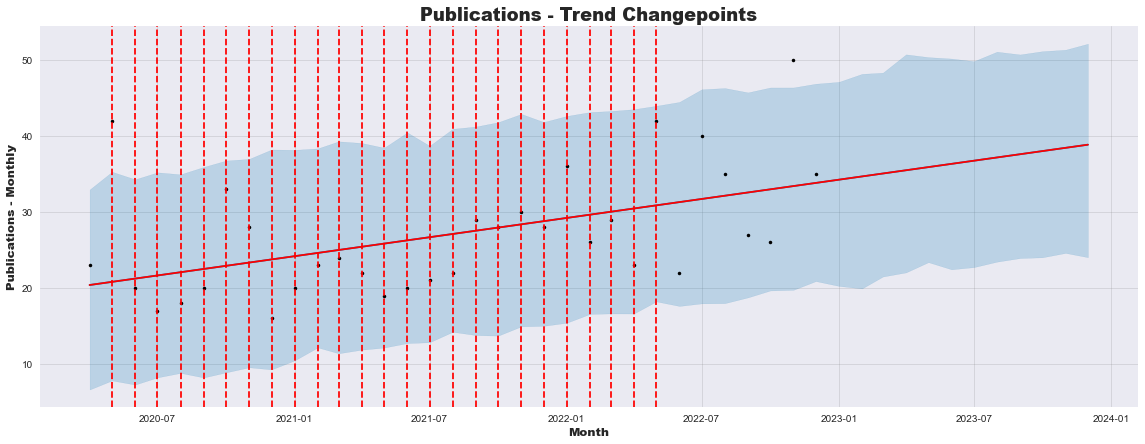

In [5]:
fig = plot(model, forecast, figsize=(16, 6));
ax = fig.gca()
add_changepoints_to_plot(ax, model, forecast, threshold=0)


ax.set_title("Publications - Trend Changepoints", size=18, fontweight='heavy')
ax.set_xlabel('Month', size = '12' , fontweight='heavy')
ax.set_ylabel('Publications - Monthly', fontweight='heavy', size = '12')

,Month,Publications,yhat_lower,yhat,yhat_upper,trend
40,2023-08-01,37.0,23.473651,37.187260,51.109365,37.187260
41,2023-09-01,37.0,23.949287,37.614804,50.743769,37.614804
42,2023-10-01,38.0,24.049682,38.028557,51.175094,38.028557
43,2023-11-01,38.0,24.624289,38.456101,51.366615,38.456101
44,2023-12-01,38.0,24.060323,38.869854,52.161665,38.869854


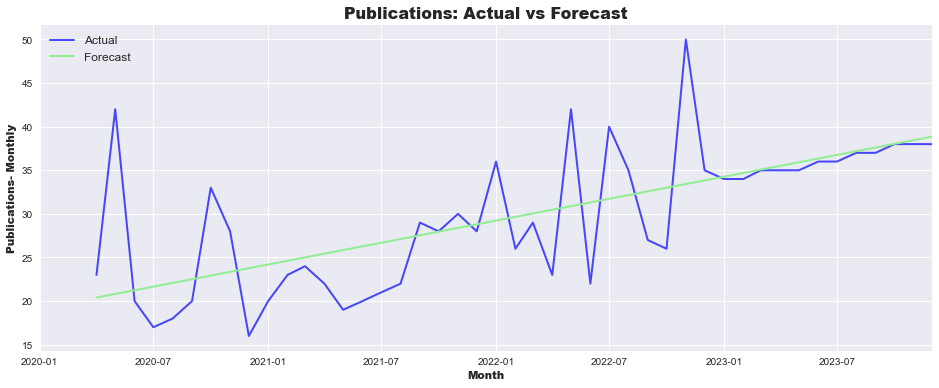

In [6]:
# Join Original Dataset With Forecast
combined_df = df.join(forecast, how = 'outer')

plt.figure(figsize=(16,6))
plt.plot(df['Month'], df['Publications'], 
         linewidth=2, color = 'blue' ,alpha = 0.7, label = 'Actual')
plt.plot(combined_df['Month'], combined_df['yhat'], 
         linewidth=2, color = 'lightgreen', label = 'Forecast')


plt.title('Publications: Actual vs Forecast', fontsize=16, fontweight='heavy' )
plt.xlabel('Month', fontweight='heavy')
plt.ylabel('Publications- Monthly', fontweight='heavy')
plt.legend(loc="upper left", fontsize = 'large')

plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2023-12-01'))
combined_df[['Month', 'Publications', 'yhat_lower' , 'yhat', 'yhat_upper' ,'trend']].tail()



(18262.0, 19692.0)

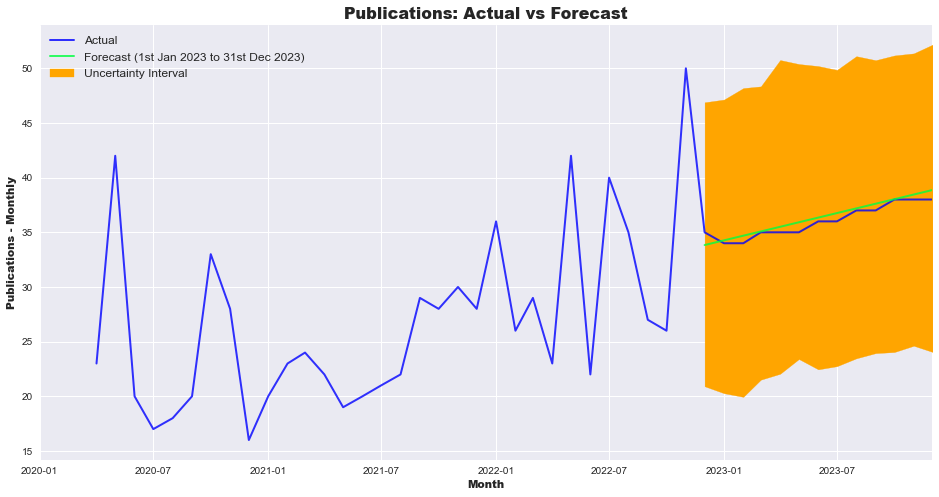

In [7]:
forecast_adj = forecast.loc[forecast['ds'] >=forecast_start_date, ['yhat_lower','yhat','yhat_upper']]
combined_df_adj = df.join(forecast_adj, how = 'outer')

plt.figure(figsize=(16,8))
plt.plot(combined_df_adj['Month'], combined_df_adj['Publications'], 
         linewidth=2, color = 'blue' ,alpha = 0.8, label = 'Actual')
plt.plot(combined_df_adj['Month'], combined_df_adj['yhat'], 
         linewidth=2, color = '#00ff41', alpha = 0.8 , label = 'Forecast (1st Jan 2023 to 31st Dec 2023)')
plt.fill_between(combined_df_adj['Month'], combined_df_adj['yhat_upper'], combined_df_adj['yhat_lower'], 
                 color='orange', label = 'Uncertainty Interval')

plt.title('Publications: Actual vs Forecast', fontsize=16, fontweight='heavy' )
plt.xlabel('Month', fontweight='heavy')
plt.ylabel('Publications - Monthly', fontweight='heavy')
plt.legend(loc="upper left", fontsize = 'large')

plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2023-12-01'))

In [8]:
combined_df_test = combined_df.loc[(combined_df['Month'] > cutoff_date)
                                    & (combined_df['Month'] <= test_end_date )]


mape =(np.mean(np.abs(combined_df_test['Publications']-combined_df_test['yhat'])/
               np.abs(combined_df_test['Publications'])))*100
print('MAPE:',  mape)

MAPE: 0.774726994588093


In [9]:
import sys
!{sys.executable} -m pip install watermark
%load_ext watermark 
%watermark 
%watermark --iversions

Last updated: 2023-01-18T14:10:25.374805+00:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 126 Stepping 5, GenuineIntel
CPU cores   : 8
Architecture: 64bit

sys       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
numpy     : 1.23.5
pandas    : 1.2.4
matplotlib: 3.3.4



In [10]:
import os
os.getcwd()
os.chdir('C:\\Users\\HollydawnMurray\\downloads')

#naming files with a timestamp
import time

TodaysDate = time.strftime("%d-%m-%Y")
KPIsfilename = "forecast_KPIs"+ TodaysDate +".xlsx"

combined_df.to_excel(KPIsfilename, index=False)  #this has created an xls file in the same directory you are working in (check downloads)
